In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from statistics import mean
import random

Using TensorFlow backend.


In [0]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [3]:
from google.colab import drive, files
drive.mount('/content/drive/')
path = "drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
x_train = pickle.load(open(path + 'x_train_seg.P', mode='rb'))
y_train = pickle.load(open(path + 'y_train_seg.P', mode='rb'))
x_val = pickle.load(open(path + 'x_val_seg.P', mode='rb'))
y_val = pickle.load(open(path + 'y_val_seg.P', mode='rb'))

In [0]:
x_train = np.reshape(x_train,(-1,64,64,1))
y_train = np.reshape(y_train,(-1,64,64,1))
x_val = np.reshape(x_val,(-1,64,64,1))
y_val = np.reshape(y_val,(-1,64,64,1))

In [0]:
def dice_coef(y_true, y_pred):
    '''
    Params: y_true -- the labeled mask corresponding to an rgb image
            y_pred -- the predicted mask of an rgb image
    Returns: dice_coeff -- A metric that accounts for precision and recall
                           on the scale from 0 - 1. The closer to 1, the
                           better.
    Citation (MIT License): https://github.com/jocicmarko/
                            ultrasound-nerve-segmentation/blob/
                            master/train.py
    '''
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    #intersection = K.sum(y_true_f * y_pred_f)
    #smooth = 1.0
    #return (2.0*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0*intersection)/(K.sum(y_true_f)+K.sum(y_pred_f))

In [0]:
def dice_coef_loss(y_true, y_pred):
    '''
    Params: y_true -- the labeled mask corresponding to an rgb image
            y_pred -- the predicted mask of an rgb image
    Returns: 1 - dice_coeff -- a negation of the dice coefficient on
                               the scale from 0 - 1. The closer to 0, the
                               better.
    Citation (MIT License): https://github.com/jocicmarko/
                            ultrasound-nerve-segmentation/blob/
                            master/train.py
    '''
    return 1-dice_coef(y_true, y_pred)

In [0]:
def IoU(y_true, y_pred):
  dice_coefficient_score = dice_coefficient(y_true, y_pred)
  return dice_coefficient_score / (2 - dice_coefficient_score)

In [0]:
def dice_coefficient(y_true, y_pred):
  y_true_f = y_true.flatten()
  y_pred_f = y_pred.flatten()
  intersection = np.sum(np.multiply(y_true, y_pred))
  return 2*intersection/(np.sum(y_true_f) + np.sum(y_pred_f))

In [0]:
def plot_n_segmented_images(n, threshold, output):
  output_resh = np.reshape(output,(-1,64,64))
  x_val_resh = np.reshape(x_val,(-1,64,64))
  y_val_resh = np.reshape(y_val,(-1,64,64))
  
  for i in range(n):
    k = random.randint(0, len(y_val))
    plt.subplot(131)
    plt.title('Output')
    plt.imshow(np.where(output_resh[k] > threshold, 1, 0), cmap='gray')
    plt.subplot(132)
    plt.title('Mask')
    plt.imshow(y_val_resh[k], cmap='gray')
    plt.subplot(133)
    plt.title('Original image ' + str(k))
    plt.imshow(x_val_resh[k], cmap='gray')
    plt.show()

##Segmentation using a CNN autoencoder with binary_crossentropy



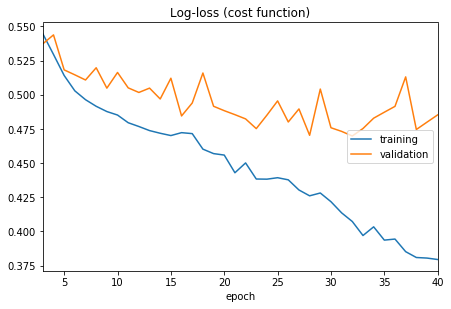

Log-loss (cost function):
training   (min:    0.379, max:    0.604, cur:    0.379)
validation (min:    0.470, max:    0.589, cur:    0.485)


In [11]:
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Dropout
from keras.models import Model

batch_size = 32
epochs = 40
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))
    
def segmenter(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    drop1 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop1)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)

    #decoder
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded

segmenter = Model(input_img, segmenter(input_img))

segmenter.compile(optimizer = 'adam',
                  loss='binary_crossentropy')

segmenter.fit(x_train, 
              y_train, 
              epochs=epochs,
              verbose=1,
              validation_data=(x_val, y_val),
              callbacks=[PlotLossesKeras()])

Dice Coefficient = 0.55
Intersection over Union = 0.39


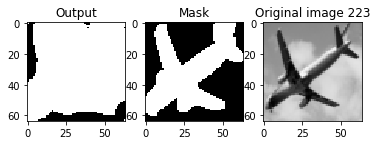

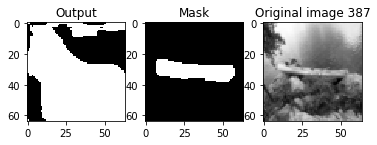

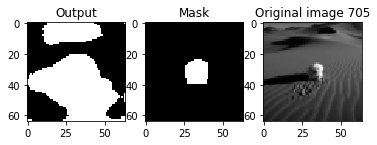

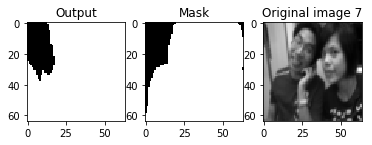

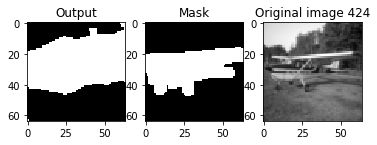

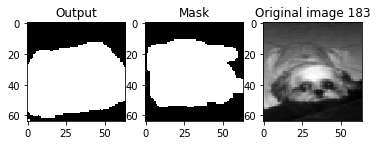

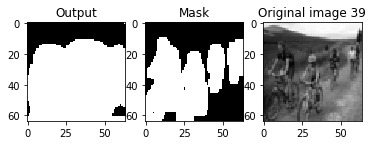

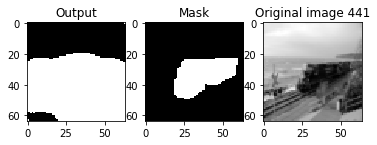

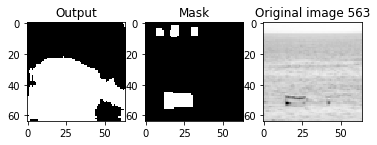

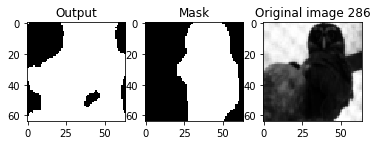

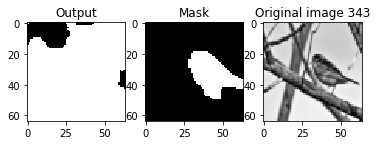

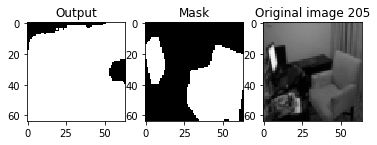

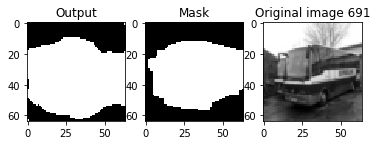

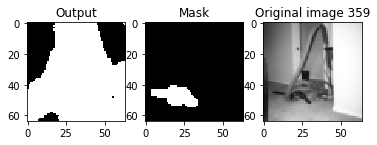

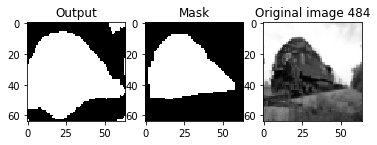

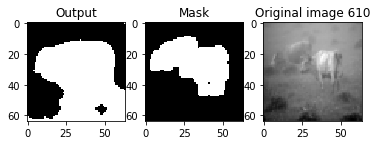

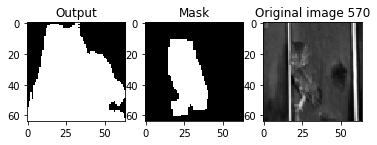

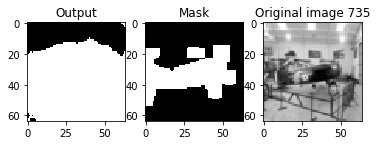

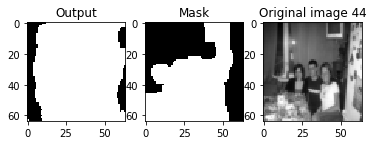

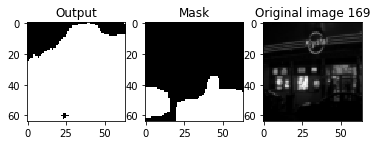

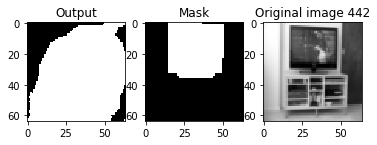

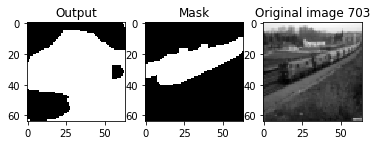

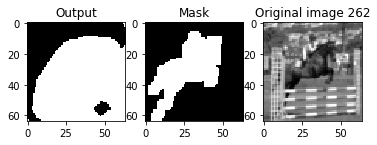

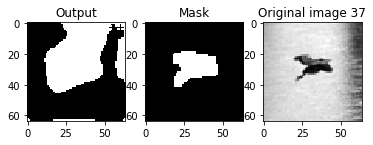

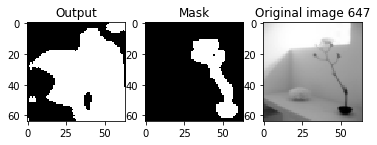

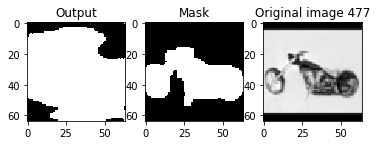

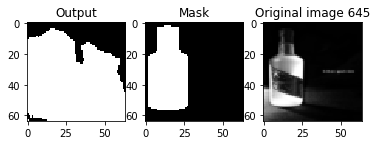

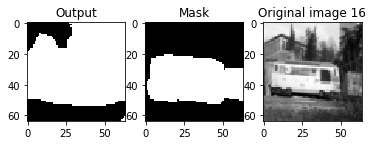

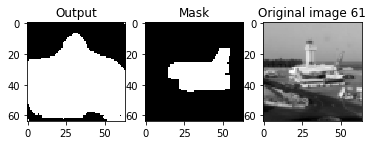

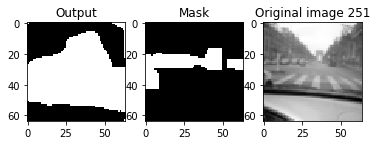

In [12]:
output = segmenter.predict(x_val)

dice_coefficient_score = mean([dice_coefficient(y_val[i], output[i]) for i in range(len(output))])
print('Dice Coefficient = %.2f' % dice_coefficient_score)

IoU_score = mean([IoU(y_val[i], output[i]) for i in range(len(output))])
print('Intersection over Union = %.2f' % IoU_score)

plot_n_segmented_images(30, 0.1, output)

##Segmentation using a CNN autoencoder with dice coeff as loss function

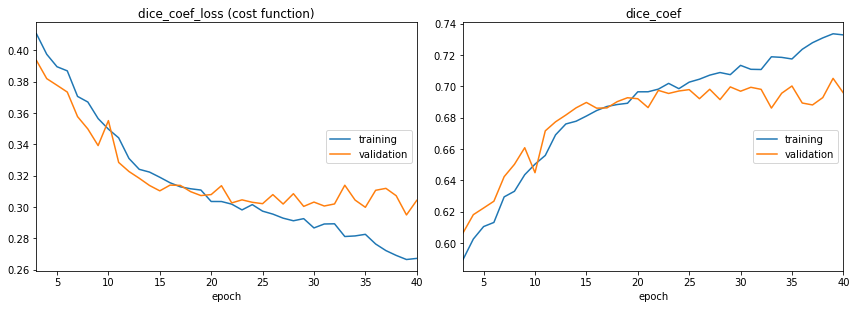

dice_coef_loss (cost function):
training   (min:    0.267, max:    0.473, cur:    0.267)
validation (min:    0.295, max:    0.414, cur:    0.304)

dice_coef:
training   (min:    0.527, max:    0.733, cur:    0.733)
validation (min:    0.586, max:    0.705, cur:    0.696)


In [13]:
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Dropout
from keras.models import Model

batch_size = 32
epochs = 40
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))
    
def segmenter_dice(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    drop1 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop1)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)

    #decoder
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded

segmenter_dice = Model(input_img, segmenter_dice(input_img))

segmenter_dice.compile(optimizer='adam',
                  loss=dice_coef_loss,
                  metrics=[dice_coef])

segmenter_dice.fit(x_train, 
              y_train, 
              epochs=epochs,
              verbose=1,
              validation_data=(x_val, y_val),
              callbacks=[PlotLossesKeras()])

Dice Coefficient = 0.68
Intersection over Union = 0.54


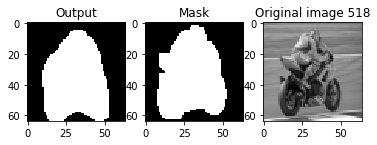

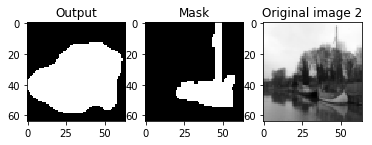

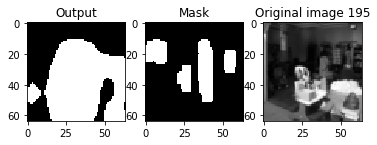

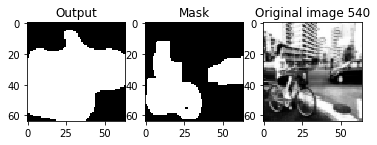

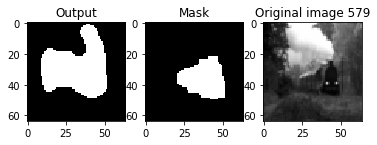

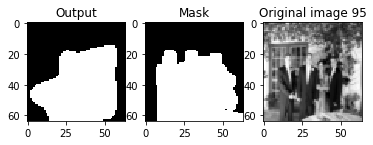

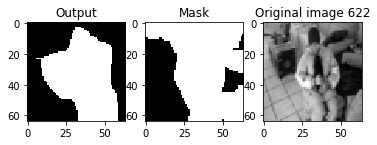

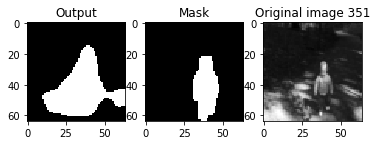

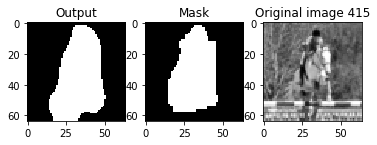

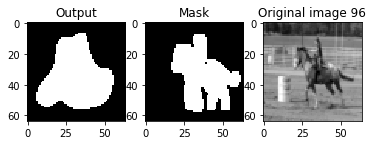

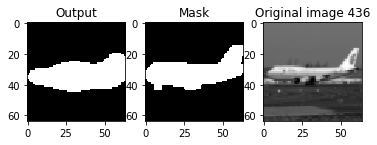

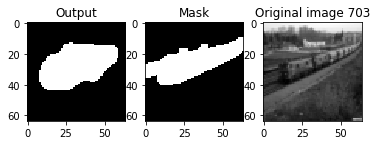

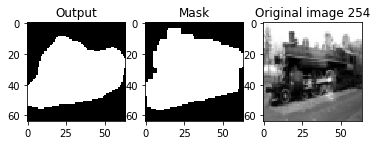

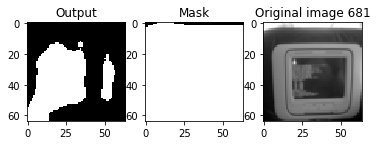

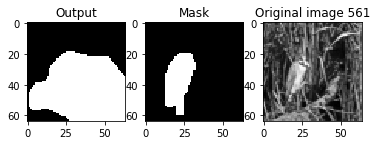

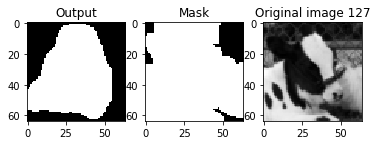

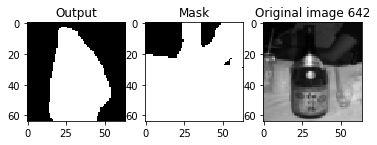

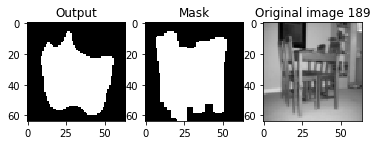

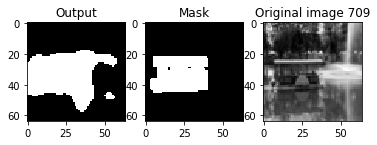

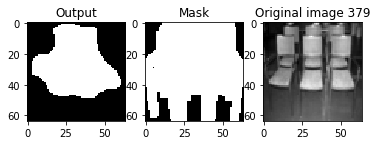

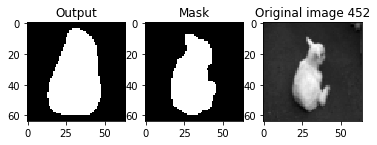

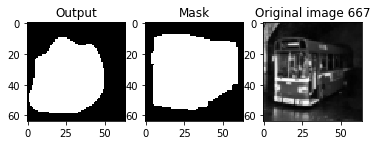

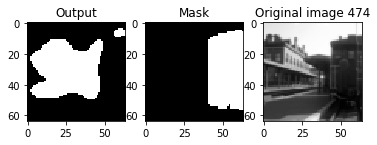

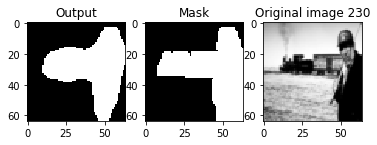

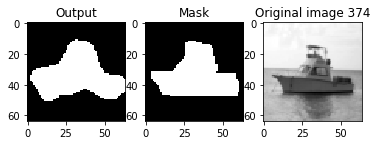

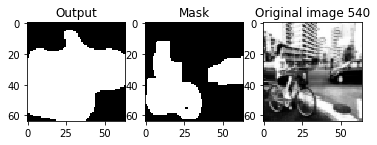

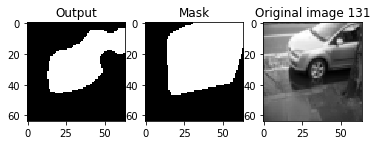

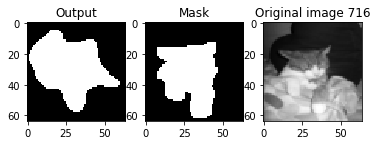

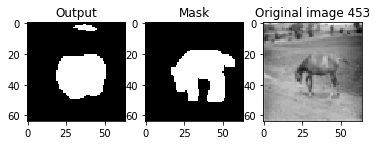

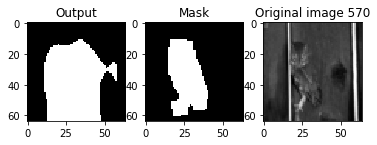

In [14]:
output_dice = segmenter_dice.predict(x_val)

dice_coefficient_score = mean([dice_coefficient(y_val[i], output_dice[i]) for i in range(len(output_dice))])
print('Dice Coefficient = %.2f' % dice_coefficient_score)

IoU_score = mean([IoU(y_val[i], output_dice[i]) for i in range(len(output_dice))])
print('Intersection over Union = %.2f' % IoU_score)

plot_n_segmented_images(30, 0.1, output_dice)

In [0]:
output_resh = np.reshape(output,(-1,64,64))
output_dice_resh = np.reshape(output_dice,(-1,64,64))
x_val_resh = np.reshape(x_val,(-1,64,64))
y_val_resh = np.reshape(y_val,(-1,64,64))

In [0]:
def plot_BCE_DC_comparison(k, threshold):
  plt.subplot(141)
  plt.title('BCE Output')
  plt.imshow(np.where(output_resh[k] > threshold, 1, 0), cmap='gray')
  plt.subplot(142)
  plt.title('DC Output')
  plt.imshow(np.where(output_dice_resh[k] > threshold, 1, 0), cmap='gray')
  plt.axis('off')
  plt.subplot(143)
  plt.title('Mask')
  plt.imshow(y_val_resh[k], cmap='gray')
  plt.axis('off')
  plt.subplot(144)
  plt.title('Original')
  plt.imshow(x_val_resh[k], cmap='gray')
  plt.axis('off')
  plt.show()

Dice Coefficient BCE = 0.57
Intersection over Union BCE = 0.40
Dice Coefficient DC = 0.82
Intersection over Union DC = 0.69


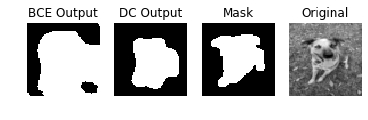

In [54]:
k = 261
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.69
Intersection over Union BCE = 0.53
Dice Coefficient DC = 0.82
Intersection over Union DC = 0.70


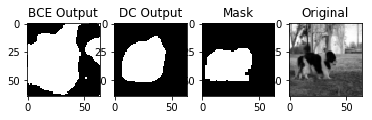

In [37]:
k = 630
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.64
Intersection over Union BCE = 0.47
Dice Coefficient DC = 0.79
Intersection over Union DC = 0.65


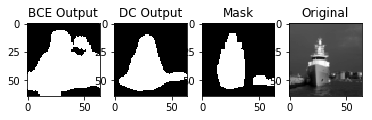

In [38]:
k = 129
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.68
Intersection over Union BCE = 0.51
Dice Coefficient DC = 0.85
Intersection over Union DC = 0.73


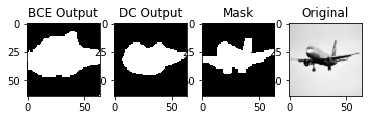

In [39]:
k = 656
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.72
Intersection over Union BCE = 0.57
Dice Coefficient DC = 0.95
Intersection over Union DC = 0.90


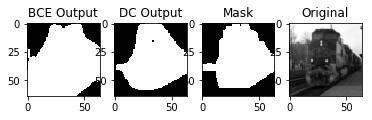

In [40]:
k = 114
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.78
Intersection over Union BCE = 0.64
Dice Coefficient DC = 0.88
Intersection over Union DC = 0.78


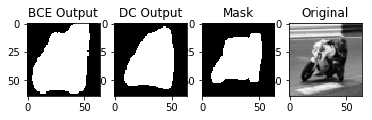

In [41]:
k = 620
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.71
Intersection over Union BCE = 0.55
Dice Coefficient DC = 0.81
Intersection over Union DC = 0.68


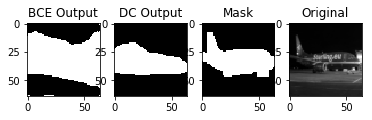

In [42]:
k = 435
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.62
Intersection over Union BCE = 0.44
Dice Coefficient DC = 0.72
Intersection over Union DC = 0.56


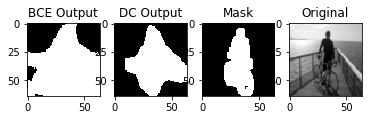

In [43]:
k = 728
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.70
Intersection over Union BCE = 0.53
Dice Coefficient DC = 0.89
Intersection over Union DC = 0.80


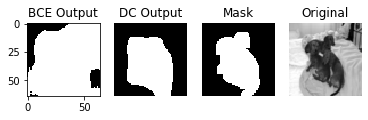

In [62]:
k = 34
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.60
Intersection over Union BCE = 0.43
Dice Coefficient DC = 0.85
Intersection over Union DC = 0.73


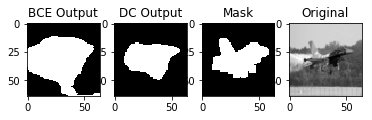

In [45]:
k = 188
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.74
Intersection over Union BCE = 0.59
Dice Coefficient DC = 0.92
Intersection over Union DC = 0.85


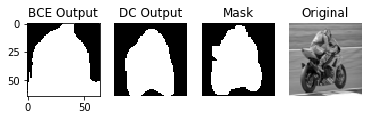

In [63]:
k = 518
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

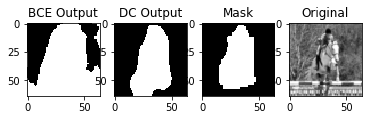

In [32]:
k = 415
threshold = 0.1

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.66
Intersection over Union BCE = 0.49
Dice Coefficient DC = 0.83
Intersection over Union DC = 0.71


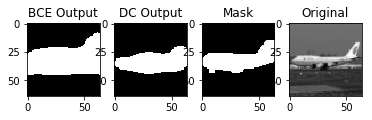

In [46]:
k = 436
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.74
Intersection over Union BCE = 0.58
Dice Coefficient DC = 0.88
Intersection over Union DC = 0.78


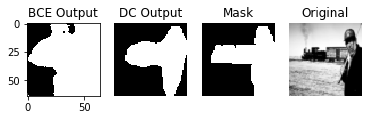

In [64]:
k = 230
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)

Dice Coefficient BCE = 0.63
Intersection over Union BCE = 0.46
Dice Coefficient DC = 0.89
Intersection over Union DC = 0.81


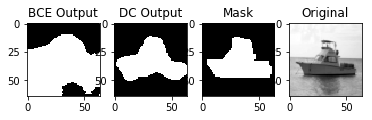

In [48]:
k = 374
threshold = 0.1

dice_coefficient_score = dice_coefficient(y_val[k], output[k])
print('Dice Coefficient BCE = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output[k])
print('Intersection over Union BCE = %.2f' % IoU_score)

dice_coefficient_score = dice_coefficient(y_val[k], output_dice[k])
print('Dice Coefficient DC = %.2f' % dice_coefficient_score)

IoU_score = IoU(y_val[k], output_dice[k])
print('Intersection over Union DC = %.2f' % IoU_score)

plot_BCE_DC_comparison(k, threshold)